# General

## Introduction

Notebook containing **software-control** EEG processing pipeline. Goal is a general purpose discrimination system for EEG data, ie. the ability to classify sample EEG traces to a few given categories.

*Authors: Dasheng Bi*

## Quick Operations

In [31]:
# Libraries for data import, preprocessing
import numpy as np
import pandas as pd

# # Visualization, clustering
import seaborn as sns
# import matplotlib.gridspec as gridspec
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# %matplotlib inline
plt.ioff()

# # KNN
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn import metrics

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# OS, Control
import os
# import sys

# Path properties
train_root = 'csv_sa_2/'
test_root = 'csv_sa_2/'
prefix = 'db-rec-'
label = ['GO_', 'STOP_']
train_number = range(1, 4)
# test_number = range(3, 4)
suffix = '.csv'

# Data properties
SAMPLE_FREQ = 256
INTERVAL = 0.4
N_COMPONENTS = 4 # raw data
# N_COMPONENTS = 20 # filtered DTABG components
TRAIN_SAMPLES = 60
TEST_SAMPLES = 36

# Spectrogram
N_SPECT_FREQS, N_SPECT_TIMES = 33, 39

########################################################################

# Audio
from scipy.io import wavfile
from scipy import signal

# Audio Path Properties
audio_root = 'sound_2/'
audio_prefix = ''
audio_suffix = '.wav'

# Audio Data Properties
AUDIO_SAMPLE_FREQ = 44100
AUDIO_EVENT_THRESHOLD_LO = 1
AUDIO_EVENT_THRESHOLD_HI = 1000
MIN_AUDIO_EVENT_LENGTH = 10000

########################################################################
# A note on labels: 1 is "go," 0 is "stop."

# Explore Data; Clustering

## Imports

In [ ]:
# Libraries for data import, preprocessing
import numpy as np
import pandas as pd

In [ ]:
# Visualization, clustering
import seaborn as sns
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

## Path Configuration

In [ ]:
# Path properties
root = 'csv1/'
prefix = 'db-rec-'
label = ['GO_', 'STOP_']
number = range(1, 6)
suffix = '.csv'

## Read Data, Select Columns

### General Attributes

In [ ]:
SAMPLE_FREQ = 256
INTERVAL = 0.5

# N_COMPONENTS = 4 # raw data
N_COMPONENTS = 20 # filtered DTABG components

TRAIN_SAMPLES = 60
TEST_SAMPLES = 8

### Explore Data Format

In [ ]:
path = root + prefix + label[0] + str(number[0]) + suffix
df = pd.read_csv(path)
print(df.columns)
df = df.drop(columns=df.columns[21:])
print(df.columns)
df = df.drop(columns=df.columns[0])
print(df.columns)
print(df.shape)

### Read in Training Data

In [ ]:
data_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
# print(data_stack)
# print(data_stack.shape)
for l in label:
    for trial in train_number:
        path = train_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.

        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
    #         print(np.argwhere(np.isnan(raw_vals)))
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
            data_stack = np.concatenate((data_stack, raw_vals), axis=0)
#         print(data_stack.shape)
df_stack = pd.DataFrame(data_stack)
# print(df_stack.head())
# num_rows=num_trials; num_cols=num_datapts
print("data_stack shape: ", data_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(data_stack))) == 0)  # Should be empty

# Labels
train_labels = [1] * TRAIN_SAMPLES + [0] * TRAIN_SAMPLES

### Read in Testing Data

In [ ]:
test_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
for l in label:
    for trial in test_number:
        path = test_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.
        
        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ * N_COMPONENTS)))
            test_stack = np.concatenate((test_stack, raw_vals), axis=0)
#             print(test_stack.shape)
df_test = pd.DataFrame(test_stack)
# print(df_stack.head())
# num_rows=num_trials; num_cols=num_datapts
print("test_stack shape: ", test_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(test_stack))) == 0)  # Should be empty

# Labels
test_labels = [1] * TEST_SAMPLES + [0] * TEST_SAMPLES

## t-SNE Clustering of Samples

In [ ]:
# t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(df_columns)

tsne_df = pd.DataFrame()

# Plot
tsne_df['tsne-2d-one'] = tsne_results[:, 0]
tsne_df['tsne-2d-two'] = tsne_results[:, 1]
# Labels
y = [1] * NUM_SAMPLES[0] + [0] * NUM_SAMPLES[1]
tsne_df['y'] = y
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=tsne_df,
    legend="full",
    alpha=0.8
)

### Playground: Multiple t-SNEs

In [ ]:
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=5, nrows=5, figure=fig)

for niter in range(250, 1500, 250):
    for perp in range(10, 55, 10):
        # multiple t-SNEs
        tsne = TSNE(n_components=2, verbose=1, perplexity=perp, n_iter=niter)
        tsne_results = tsne.fit_transform(df_columns)
        
        tsne_df = pd.DataFrame()
        
        coord_prefix = 'tsne-2d-'
        coord_desc = str(niter) + '-' + str(perp)
        x_coord = coord_prefix + coord_desc + '-one'
        y_coord = coord_prefix + coord_desc + '-two'
        tsne_df[x_coord] = tsne_results[:, 0]
        tsne_df[y_coord] = tsne_results[:, 1]

        # Labels
        y = [1] * NUM_SAMPLES[0] + [0] * NUM_SAMPLES[1]
        tsne_df['y'] = y

        niter_offset = int((niter-250)/250)
        perp_offset = int((perp-10)/10)
        fig.add_subplot(spec[niter_offset, perp_offset])
        sns.scatterplot(
            x=x_coord, y=y_coord,
            hue="y",
            palette=sns.color_palette("hls", 2),
            data=tsne_df,
            legend="full",
            alpha=0.8,
        )

## PCA Clustering of Samples

In [ ]:
# PCA
pca = PCA(n_components=50)
pca_result = pca.fit_transform(df_columns)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum:', sum(pca.explained_variance_ratio_))
## Explained variation per principal component: [0.1557712  0.11314638 0.08842925]

# Labels
y = [1] * NUM_TRAIN_SAMPLES[0] \
    + [2] * NUM_TEST_SAMPLES[0] \
    + [0] * NUM_TRAIN_SAMPLES[1] \
    + [3] * NUM_TEST_SAMPLES[1]

# Plot: 3d
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_result[:,0], 
    ys=pca_result[:,1], 
    zs=pca_result[:,2], 
    c=y, 
    cmap='jet',
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

# Plot: 2d
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1],
    hue=y,
    palette=sns.color_palette("hls", 4),
    legend="full",
    alpha=0.8
)

# Audio Data Augmentation

## Imports

In [ ]:
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt

## Extract Synchronized Events from Audio/EEG Data

GO_
#### ***********************************************************************************82 #### **********************************************************************69 #### ************************************35 

STOP_
#### ****************************************************************************75 #### ***************************************************************************************86 #### **********************************************45 

data_stack shape:  (392, 102, 4)
spects_stack shape:  (392, 4, 33, 39)
confirm no NaN: True
[186, 206]


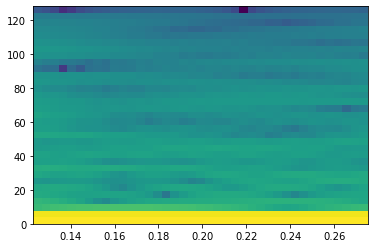

In [32]:
def to_eeg_index(audio_index):
    return int(audio_index / AUDIO_SAMPLE_FREQ * SAMPLE_FREQ)

END = to_eeg_index(INTERVAL * AUDIO_SAMPLE_FREQ) # Produce training samples of uniform length.

df_columns = np.empty((0, int(END * N_COMPONENTS)))
data_stack = np.empty((0, END, N_COMPONENTS))
spects_stack = np.empty((0, N_COMPONENTS, N_SPECT_FREQS, N_SPECT_TIMES)) # Spectrogram dimensions are particular.

NUM_SAMPLES = []

for l in label:
    print(l)
    event_cts = 0
    for trial in train_number:
        print('####', end=' ')
        ### READ AUDIO DATA
        audio_path = audio_root + audio_prefix + l + str(trial) + audio_suffix
        _, samples = wavfile.read(audio_path)
        envelope = np.abs(signal.hilbert(samples))
        
        ### GET AUDIO EVENTS
        events = np.empty((0, 2))
        in_event = False
        new_event = np.zeros((1, 2))
        hi_threshold_check = False
        for s in range(len(samples)):
            if (not in_event) and (envelope[s] >= AUDIO_EVENT_THRESHOLD_LO):
                in_event = True
                new_event[0][0] = s
            elif (in_event) and (envelope[s] < AUDIO_EVENT_THRESHOLD_LO):
                in_event = False
                new_event[0][1] = s
                event_length = new_event[0][1] - new_event[0][0]
                if hi_threshold_check and event_length >= MIN_AUDIO_EVENT_LENGTH:
#                     print(new_event[0][1] - new_event[0][0], end=' ') # Verbose Progress bar
                    print('*', end='') # Simplified progress bar
                    events = np.concatenate((events, new_event), axis=0)
                    hi_threshold_check = False
            elif (in_event) and (envelope[s] >= AUDIO_EVENT_THRESHOLD_HI):
                hi_threshold_check = True

        ### READ EEG DATA
        cortical_path = train_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(cortical_path)
        
        
        df = df.drop(columns=df.columns[25:])
        df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

#         df = df.drop(columns=df.columns[21:])
#         df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.

        ### EXTRACT EEG EVENTS FROM AUDIO EVENTS (EACH EVENT IS A DATAPOINT)
        cts = 0
        for e in events:
            cts += 1
            event_cts += 1
            
            START = to_eeg_index(e[0])

            raw = df.iloc[START:]
            if (raw.equals(raw.dropna()) == False):
                # print('Dropped NaN: %s%d, sample %d' %(l, trial, ct))
                raw = raw.dropna()
            raw = raw.iloc[:END]
            raw_vals = raw.values
            raw_vals = np.reshape(
                raw_vals, (1, END, N_COMPONENTS)) # Split into N_COMPONENTS channels
            data_stack = np.concatenate((data_stack, raw_vals), axis=0)
            
            ### GENERATE SPECTROGRAMS
            spects = np.empty((0, N_SPECT_FREQS, N_SPECT_TIMES))
            for ch in range(N_COMPONENTS):
                ch_raw = raw_vals[0, :, ch]
                ch_spect, freqs_spect, times_spect, image_spect = plt.specgram(
                    ch_raw, NFFT=64, Fs=SAMPLE_FREQ, noverlap=63)
                ch_spect = np.reshape(ch_spect, (1, N_SPECT_FREQS, N_SPECT_TIMES))
                spects = np.concatenate((spects, ch_spect), axis=0) # Channels in one datapoint
            
            spects = np.reshape(spects, (1, N_COMPONENTS, N_SPECT_FREQS, N_SPECT_TIMES))
            log_spects = np.log(spects) # take the ln of the spectrum.
            spects_stack = np.concatenate((spects_stack, log_spects), axis=0) # The tensor corresponding to this datapoint

            ### FOR CLUSTERING PURPOSES
            df_col = np.reshape(
                raw_vals, (1, int(END * N_COMPONENTS))) # One vector of df_stack
            df_columns = np.concatenate((df_columns, df_col), axis=0)
                    
            
        print('*' + str(cts), end=' ') # Progress bar
        
    NUM_SAMPLES = NUM_SAMPLES + [event_cts]
    print('\n')

df_stack = pd.DataFrame(df_columns) # Will only work when data is combined.
# print(df_stack.head())
print("data_stack shape: ", data_stack.shape)
print("spects_stack shape: ", spects_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(data_stack))) == 0)  # Should be empty

# Labels: 1=GO, 0=STOP
data_labels = [1] * NUM_SAMPLES[0] + [0] * NUM_SAMPLES[1]
print(NUM_SAMPLES)

### Split Data into Train/Test Sets

In [33]:
NUM_TRAIN_SAMPLES = [150, 150]
NUM_TEST_SAMPLES = [36, 36]

### SINGLE CHANNEL
# train_df = df_stack.iloc[np.r_[
#     0:NUM_TRAIN_SAMPLES[0], 
#     NUM_SAMPLES[0]:NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]]]
# test_df = df_stack.iloc[np.r_[
#     NUM_TRAIN_SAMPLES[0]:NUM_SAMPLES[0],
#     NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]:NUM_SAMPLES[0]+NUM_SAMPLES[1]]]
# train_stack = train_df.values
# test_stack = test_df.values

### SPLIT CHANNEL
# train_stack = data_stack[np.r_[
#     0:NUM_TRAIN_SAMPLES[0], 
#     NUM_SAMPLES[0]:NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]], :, :]
# test_stack = data_stack[np.r_[
#     NUM_TRAIN_SAMPLES[0]:NUM_TRAIN_SAMPLES[0]+NUM_TEST_SAMPLES[0],
#     NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]:NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]+NUM_TEST_SAMPLES[1]], :, :]
# print(train_stack.shape, test_stack.shape)
# train_data = np.split(train_stack, N_COMPONENTS, axis=2)
# test_data = np.split(test_stack, N_COMPONENTS, axis=2)

### SPECTROGRAM
train_stack = spects_stack[np.r_[
    0:NUM_TRAIN_SAMPLES[0],
    NUM_SAMPLES[0]:NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]], :, :, :]
test_stack = spects_stack[np.r_[
    NUM_TRAIN_SAMPLES[0]:NUM_TRAIN_SAMPLES[0]+NUM_TEST_SAMPLES[0],
    NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]:NUM_SAMPLES[0]+NUM_TRAIN_SAMPLES[1]+NUM_TEST_SAMPLES[1]], :, :, :]
print(train_stack.shape, test_stack.shape)
train_data_ch_split = np.split(train_stack, N_COMPONENTS, axis=1)
test_data_ch_split = np.split(test_stack, N_COMPONENTS, axis=1)
print(len(train_data_ch_split), train_data_ch_split[0].shape)
print(len(test_data_ch_split), test_data_ch_split[0].shape)

### CONVNET
train_data_spect = np.swapaxes(train_stack, 1, 3)
test_data_spect = np.swapaxes(test_stack, 1, 3)
print(train_data_spect.shape, test_data_spect.shape)

# Labels: 1=GO, 0=STOP
train_labels = np.asarray([1] * NUM_TRAIN_SAMPLES[0] + [0] * NUM_TRAIN_SAMPLES[1])
test_labels = np.asarray([1] * NUM_TEST_SAMPLES[0] + [0] * NUM_TEST_SAMPLES[1])

# train_labels = np.concatenate(
#     (np.tile([0, 1], (NUM_TRAIN_SAMPLES[0], 1)), # GO
#      np.tile([1, 0], (NUM_TRAIN_SAMPLES[1], 1))) # STOP
# )
# test_labels = np.concatenate(
#     (np.tile([0, 1], (NUM_TEST_SAMPLES[0], 1)), # GO
#      np.tile([1, 0], (NUM_TEST_SAMPLES[1], 1))) # STOP
# )
print(train_labels.shape, test_labels.shape)


(300, 4, 33, 39) (72, 4, 33, 39)
4 (300, 1, 33, 39)
4 (72, 1, 33, 39)
(300, 39, 33, 4) (72, 39, 33, 4)
(300,) (72,)


### Explore Spectrograms

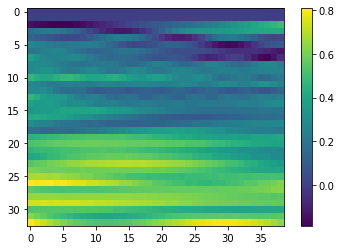

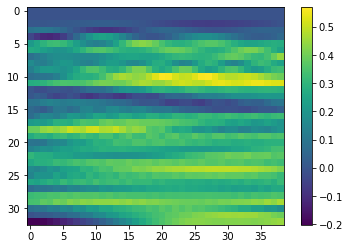

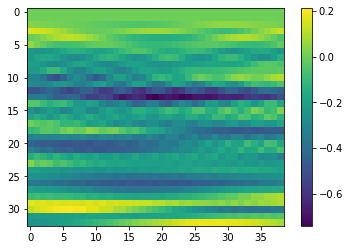

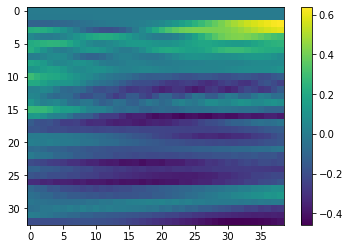

In [28]:
go_mean, stop_mean = [], []
for ch in range(N_COMPONENTS):
    train_data_this_channel = train_data_ch_split[ch]
    go_mean_ch = np.mean(train_data_this_channel[0:NUM_TRAIN_SAMPLES[0], :, :, :], axis=0)[0, :, :]
    stop_mean_ch = np.mean(train_data_this_channel[NUM_TRAIN_SAMPLES[0]:, :, :, :], axis=0)[0, :, :]
    diff_mean_ch = np.abs(go_mean_ch - stop_mean_ch)
    log_go_mean_ch = np.log(go_mean_ch)
    log_stop_mean_ch = np.log(stop_mean_ch)
    log_diff_mean_ch = np.log(diff_mean_ch)
    diff_log_mean_ch = log_go_mean_ch - log_stop_mean_ch
#     plt.imshow(log_go_mean_cdiff_mean_ch
#     plt.show()
#     plt.imshow(log_stop_mean_ch)
#     plt.show()
    plt.imshow(diff_log_mean_ch)
    plt.colorbar()
    plt.show()
#     go_mean = go_mean + [go_mean_ch]
#     stop_mean = stop_mean + [stop_mean_ch]
# print(len(go_mean), go_mean[0].shape)

## plot on log scale

## Read and Plot Audio Data

In [ ]:
audio_path = audio_root + audio_prefix + label[1] + str(1) + audio_suffix
print(audio_path)
sample_rate, samples = wavfile.read(audio_path)
plt.figure(figsize=(16,10))
plt.plot(samples[:], )
plt.ylabel('Amplitude')
plt.xlabel('Sample')
plt.show()

## Extract Events from Audio Data

In [ ]:
AUDIO_EVENT_THRESHOLD_LO = 1
AUDIO_EVENT_THRESHOLD_HI = 1000
AUDIO_PLT_LEFT, AUDIO_PLT_RIGHT = 0, len(envelope)
envelope = np.abs(signal.hilbert(samples))
threshold_lo = np.ones(len(envelope)) * AUDIO_EVENT_THRESHOLD_LO
threshold_hi = np.ones(len(envelope)) * AUDIO_EVENT_THRESHOLD_HI

plt.figure(figsize=(16,10))
plt.xlabel('Sample Coordinate'); plt.ylabel('Amplitude')
plt.plot(samples[AUDIO_PLT_LEFT:AUDIO_PLT_RIGHT], label='raw')
plt.plot(envelope[AUDIO_PLT_LEFT:AUDIO_PLT_RIGHT], label='envelope')
plt.plot(threshold_lo[AUDIO_PLT_LEFT:AUDIO_PLT_RIGHT], label='threshold_lo')
plt.plot(threshold_hi[AUDIO_PLT_LEFT:AUDIO_PLT_RIGHT], label='threshold_hi')

plt.show()

events = np.empty((0, 2))
in_event = False
new_event = np.zeros((1, 2))
hi_threshold_check = False

for s in range(len(samples)):
    if (not in_event) and (envelope[s] >= AUDIO_EVENT_THRESHOLD_LO):
        in_event = True
        new_event[0][0] = s
    elif (in_event) and (envelope[s] < AUDIO_EVENT_THRESHOLD_LO):
        in_event = False
        new_event[0][1] = s
        if hi_threshold_check:
            events = np.concatenate((events, new_event), axis=0)
            hi_threshold_check = False
    elif (in_event) and (envelope[s] >= AUDIO_EVENT_THRESHOLD_HI):
        hi_threshold_check = True

print(events, len(events))

for e in events:
    print(e[1]-e[0])

# Inference via KNN in PCA Space

## Imports

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

## Embed Sample into PCA Space

In [ ]:
def embed_pca(raw_eeg, pca_components):
    """
    Embeds RAW_EEG into the PCA representation space given by PCA_COMPONENTS
    """
    return np.dot(pca_components, raw_eeg.T).T

In [ ]:
train_stack_pca = embed_pca(train_stack, pca.components_)
print(train_stack_pca.shape)
test_stack_pca = embed_pca(test_stack, pca.components_)
print(test_stack_pca.shape)

### Playground: Embedding one sample into PCA Space

In [ ]:
# Procedure for obtaining one sample's representation in PCA space
sample = data_stack[0,:]
print(sample.shape)
sample_rep = np.dot(pca_components, sample)

## KNN Classifier

### Playground: Test Different k-values

In [ ]:
k_range = range(1, 51)
scores_list = []
TEST_TO_TRAIN_WEIGHT = 5
total_stack_pca = np.concatenate(
    (np.tile(test_stack_pca,
             (TEST_TO_TRAIN_WEIGHT, 1)),
     train_stack_pca))
total_labels = np.concatenate(
    (np.tile(test_labels,
             (TEST_TO_TRAIN_WEIGHT)),
     train_labels))
print(total_stack_pca.shape)
print(total_labels.shape)
for k_val in k_range:
    knn = KNeighborsClassifier(n_neighbors=k_val)
    knn.fit(train_stack_pca, train_labels)
    knn_predict = knn.predict(test_stack_pca)
    scores_list.append(metrics.accuracy_score(test_labels, knn_predict))

print('Maximum accuracy is %f' % (np.amax(scores_list)))

### Plot KNN Results

In [ ]:
sns.lineplot(x=k_range, y=scores_list)

# Neural Network Approaches

## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Read in Data to tf.data.Dataset

### Read into Numpy Array

#### Training Data

In [ ]:
train_root = 'csvc/'
test_root = 'csvc/'
train_number = range(1, 6)
test_number = range(6, 9)

In [ ]:
data_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
# print(data_stack.shape)

for l in label:
    for trial in train_number:
        path = train_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.
        
#         print(df.shape)

        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
            data_stack = np.concatenate((data_stack, raw_vals), axis=0)
#         print(data_stack.shape)
        
print("data_stack shape: ", data_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(data_stack))) == 0)  # Should be empty

#### Testing

In [ ]:
test_stack = np.empty((0, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
for l in label:
    for trial in test_number:
        path = test_root + prefix + l + str(trial) + suffix
        df = pd.read_csv(path)

#         df = df.drop(columns=df.columns[25:])
#         df = df.drop(columns=df.columns[0:21])  # Only keep raw EEG data.

        df = df.drop(columns=df.columns[21:]) # drop raw columns
        df = df.drop(columns=df.columns[0]) # Keep only DTABG filtered components.
        
        if (df.equals(df.dropna()) == False):
            print("Dropped NaN: \n", np.argwhere(np.isnan(df.values)))
            df = df.dropna()  # Drop NaN (blank) datapts.

        OFFSET = 1
        while OFFSET < 7:
            START = int(OFFSET * SAMPLE_FREQ)
            END = int(START + SAMPLE_FREQ * INTERVAL)
            OFFSET += 0.5

            raw = df.iloc[START:END]  # Select by row
            raw_vals = raw.values
            raw_vals = np.reshape(
                raw_vals, (1, int(INTERVAL * SAMPLE_FREQ), N_COMPONENTS))
            test_stack = np.concatenate((test_stack, raw_vals), axis=0)
#             print(test_stack.shape)
# df_test = pd.DataFrame(test_stack)
# print(df_stack.head())
# num_rows=num_trials; num_cols=num_datapts
print("test_stack shape: ", test_stack.shape)
print("confirm no NaN:", len(np.argwhere(np.isnan(test_stack))) == 0)  # Should be empty

#### Labels

In [ ]:
# Labels
train_labels = np.concatenate(
    (np.tile([0, 1], (NUM_TRAIN_SAMPLES[0], 1)), # GO
     np.tile([1, 0], (NUM_TRAIN_SAMPLES[1], 1))) # STOP
)
test_labels = np.concatenate(
    (np.tile([0, 1], (NUM_TEST_SAMPLES[0], 1)), # GO
     np.tile([1, 0], (NUM_TEST_SAMPLES[1], 1))) # STOP
)
# [0 1]=GO, [1 0]=STOP

### Create tf.data.Dataset from tensor slices

In [ ]:
FULL_DATASET_SIZE = NUM_TRAIN_SAMPLES[0] + NUM_TRAIN_SAMPLES[1]
TRAIN_SIZE = int(FULL_DATASET_SIZE * 0.8)
VALIDATION_SIZE = int(FULL_DATASET_SIZE * 0.2)

TRAIN_BATCH_SIZE = 1
VALIDATION_BATCH_SIZE = 1

full_dataset = tf.data.Dataset.from_tensor_slices(
    (train_stack, train_labels)
).shuffle(FULL_DATASET_SIZE)

train_dataset = full_dataset.take(TRAIN_SIZE).batch(TRAIN_BATCH_SIZE)
validation_dataset = full_dataset.skip(TRAIN_SIZE).take(VALIDATION_SIZE).batch(VALIDATION_BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_stack, test_labels))
TEST_SHUFFLE_BUFFER = NUM_TEST_SAMPLES[0] + NUM_TEST_SAMPLES[1]
TEST_BATCH_SIZE = 1
test_dataset = test_dataset.shuffle(TEST_SHUFFLE_BUFFER).batch(TEST_BATCH_SIZE)

In [ ]:
print(train_dataset, validation_dataset, test_dataset)

## Build the Model with Keras

### A Basic Convolutional Neural Network
* doesn't generalize

In [ ]:
input_shape = (int(SAMPLE_FREQ * INTERVAL), N_COMPONENTS, 1)
raw_shape = (2040, 1)
inputs = keras.Input(shape=raw_shape)
# A proposed architecture is to use recurrent first to "summarize,"
    # No need for embedding layer in recurrent subnetwork?
# then use convolutional to classify.

# reshape
reshape = layers.Reshape((int(SAMPLE_FREQ * INTERVAL), N_COMPONENTS, 1), input_shape=raw_shape)
first_conv = layers.Conv2D(16, 3, activation='relu')
first_pool = layers.MaxPool2D(pool_size=(2, 1))
second_conv = layers.Conv2D(32, 3, activation='relu')
second_pool = layers.MaxPool2D(pool_size=(2, 1))
third_conv = layers.Conv2D(64, 3, activation='relu')
flattener = layers.Flatten()
first_dense = layers.Dense(64, activation='relu')
second_dense = layers.Dense(16, activation='relu')
third_dense = layers.Dense(2)

outputs = third_dense(
    second_dense(first_dense(
        flattener(
            third_conv(
                second_pool(second_conv(
                    first_pool(first_conv(reshape(inputs))))))))))

model = keras.Model(inputs=inputs, outputs=outputs, name='simple_conv')
model.summary()

### A Basic Recurrent Neural Network
* doesn't work well

In [ ]:
input_shape = (int(SAMPLE_FREQ * INTERVAL), N_COMPONENTS)
raw_shape = (2040,1)
inputs = keras.Input(shape=raw_shape)

reshape = layers.Reshape(input_shape, input_shape=raw_shape)
recurr_layer = layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1)
first_dense = layers.Dense(64, activation='sigmoid')
result_dense = layers.Dense(2, activation='sigmoid')

outputs = result_dense(
        first_dense(
            recurr_layer(reshape(inputs))))

model = keras.Model(inputs=inputs, outputs=outputs, name='simple_lstm')
model.summary()

### A Multi-Channel Recurrent-->Dense Neural Network
* works ok

In [ ]:
sg_ch_input_shape = (END, 1)
LSTM_REDUCE_DIM = 64

channel_inputs, recurr_layers = [], []
for ch in range(N_COMPONENTS):
    channel_inputs = channel_inputs + [keras.Input(shape=sg_ch_input_shape)]
    print('channel_inputs:', channel_inputs[ch].shape)
    recurr_layers = recurr_layers + [layers.LSTM(LSTM_REDUCE_DIM)(channel_inputs[ch])]
    print('recurr_layer:', recurr_layers[ch].shape)
    
recurr_outs = layers.concatenate(recurr_layers)
first_dense = layers.Dense(64, activation='tanh')(recurr_outs)
dropout = layers.Dropout(0.1)(first_dense)
output = layers.Dense(1, activation='sigmoid')(dropout)

model = keras.Model(inputs=channel_inputs, outputs=output)

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, 'multi-channel_recurrent.png', show_shapes=True)

### Spectrogram Convolutional Neural Network
* doesn't work well

In [ ]:
spect_input_shape = (N_SPECT_TIMES, N_SPECT_FREQS, N_COMPONENTS)
inputs = keras.Input(shape=spect_input_shape)

first_conv = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
first_pool = layers.MaxPooling2D((2, 2))(first_conv)
second_conv = layers.Conv2D(64, (3, 3), activation='relu')(first_pool)
second_pool = layers.MaxPooling2D((2, 2))(second_conv)
third_conv = layers.Conv2D(64, (3, 3), activation='relu')(second_pool)
flattener = layers.Flatten()(third_conv)
first_dense = layers.Dense(64, activation='relu')(flattener)
output = layers.Dense(1)(first_dense)

model = keras.Model(inputs=inputs, outputs=output)
model.summary()
keras.utils.plot_model(model, show_shapes=True)

### Split-Channel Recurrent-Convolutional Neural Network (SpecTransformerNet)

In [34]:
sg_ch_spectrogram_shape = (1, N_SPECT_FREQS, N_SPECT_TIMES)
LSTM_IN_SHAPE = (N_SPECT_TIMES, 1)
LSTM_OUT_DIM = N_SPECT_TIMES

spects_inputs, recurr_combined = [], []
for ch in range(N_COMPONENTS):
    # spectrogram from each EEG channel (4 spectrograms)
    spects_inputs = spects_inputs + [keras.Input(shape=sg_ch_spectrogram_shape)]
    recurr_this_channel = []
    for freq in range(N_SPECT_FREQS):
        slice_freq = layers.Lambda(lambda x: x[:, 0, freq, :])(spects_inputs[ch]) # slice to (N_SPECT_TIMES,)
        reshape_for_recurr = layers.Reshape(LSTM_IN_SHAPE)(slice_freq)
        # multi-channel recurrent net (transformer?)
        recurr_this_channel = recurr_this_channel + [layers.LSTM(LSTM_OUT_DIM)(reshape_for_recurr)]
        print('*', end='') # progress bar
    # concat recurrent layers
    recurr_combined = recurr_combined + [layers.Lambda(
        lambda x: tf.stack(x, axis=2))(
            recurr_this_channel)]
    print('#', recurr_combined[ch].shape)
# feature image with 4 "spatial channels" (2d * 4)
transformed_spect_combined = layers.Lambda(
        lambda x: tf.stack(x, axis=3))(
                recurr_combined)
print(transformed_spect_combined.shape)
# ConvNet
first_conv = layers.Conv2D(16, (3, 3), activation='relu')(transformed_spect_combined)
first_pool = layers.MaxPooling2D((2, 2))(first_conv)
second_conv = layers.Conv2D(32, (3, 3), activation='relu')(first_pool)
second_pool = layers.MaxPooling2D((2, 2))(second_conv)
third_conv = layers.Conv2D(64, (3, 3), activation='relu')(second_pool)
flatten = layers.Flatten()(third_conv)
first_dense = layers.Dense(64, activation='relu')(flatten)
output = layers.Dense(1)(first_dense)

model = keras.Model(inputs=spects_inputs, outputs=output)
# model.summary()
# keras.utils.plot_model(model, 'split-channel_recurr_conv_net.png', show_shapes=True)

*********************************# (None, 39, 33)
*********************************# (None, 39, 33)
*********************************# (None, 39, 33)
*********************************# (None, 39, 33)
(None, 39, 33, 4)


### Compile Model

In [48]:
model.compile(optimizer='RMSprop',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10, verbose=1, validation_data=validation_dataset) # with tf.dataset

In [ ]:
# Multi-Channel Recurrent
history = model.fit(train_data, train_labels, batch_size=8, epochs=30, validation_split=0.2, verbose=1) # split channels

In [ ]:
### SpectConvNet
history = model.fit(train_data_spect, train_labels, batch_size=8, epochs=20, validation_split=0.2, verbose=1)

In [49]:
### SpectRecurConvNet
history = model.fit(train_data_ch_split, train_labels, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
19/19 [==============================] - 28s 1s/step - loss: 0.6667 - accuracy: 0.5733
Epoch 2/20
19/19 [==============================] - 28s 1s/step - loss: 0.6534 - accuracy: 0.6100
Epoch 3/20
19/19 [==============================] - 29s 2s/step - loss: 0.6636 - accuracy: 0.6033
Epoch 4/20
19/19 [==============================] - 29s 2s/step - loss: 0.6493 - accuracy: 0.5900
Epoch 5/20
19/19 [==============================] - 29s 2s/step - loss: 0.6476 - accuracy: 0.6267
Epoch 6/20
19/19 [==============================] - 28s 1s/step - loss: 0.6623 - accuracy: 0.5767
Epoch 7/20
19/19 [==============================] - 27s 1s/step - loss: 0.6487 - accuracy: 0.6033
Epoch 8/20
19/19 [==============================] - 27s 1s/step - loss: 0.6490 - accuracy: 0.6233
Epoch 9/20
19/19 [==============================] - 27s 1s/step - loss: 0.6472 - accuracy: 0.5933
Epoch 10/20
19/19 [==============================] - 26s 1s/step - loss: 0.6402 - accuracy: 0.6133
Epoch 11/20
19/19 [

## Training Statistics

KeyError: 'val_accuracy'

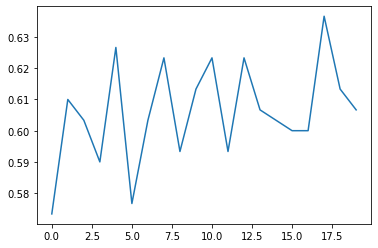

In [50]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Test Model

In [51]:
test_loss, test_acc = model.evaluate(test_data_ch_split, test_labels)

3/3 [==============================] - 1s 302ms/step - loss: 0.7650 - accuracy: 0.4444


In [52]:
test_output = model.predict(test_data_ch_split)
round_test_out = list(map(np.round, np.concatenate(test_output)))

In [53]:
test_output[:,0]

array([-1.2029692e-01, -8.3148646e-01, -5.8236736e-01,  2.1287683e-01,
       -6.6941828e-01,  6.5057027e-01,  2.5729120e-01, -5.5620474e-01,
       -6.7498046e-01, -1.5435274e-01, -9.7149986e-01, -7.3819512e-01,
       -5.7303971e-01, -8.5649776e-01,  3.2033231e-02, -6.4368653e-01,
       -7.2627407e-01, -4.5129916e-01, -2.7352118e-01, -4.0053129e-01,
       -8.9774758e-01, -4.4388506e-01, -3.4864622e-01, -6.0574286e-02,
       -5.6771749e-01, -2.7222440e-01,  1.3486354e-04, -2.8757763e-01,
        8.6314386e-01, -4.2860344e-01, -1.9288732e-01, -6.9745344e-01,
        1.8808454e-01, -5.6730372e-01, -3.4869662e-01,  1.9952738e-01,
       -8.7363380e-01, -1.7435123e-01,  3.4536320e-01, -6.3934237e-01,
        4.2779282e-02, -5.7878006e-01,  5.1275992e-01, -2.2919559e-01,
        1.1431358e+00, -3.3639315e-01, -7.4341613e-01, -6.9781601e-01,
       -1.2932773e-01, -9.1740638e-01, -2.2535609e-01,  5.1921260e-01,
       -1.0419468e+00, -9.5608419e-01, -2.9716370e-01, -6.4352053e-01,
      

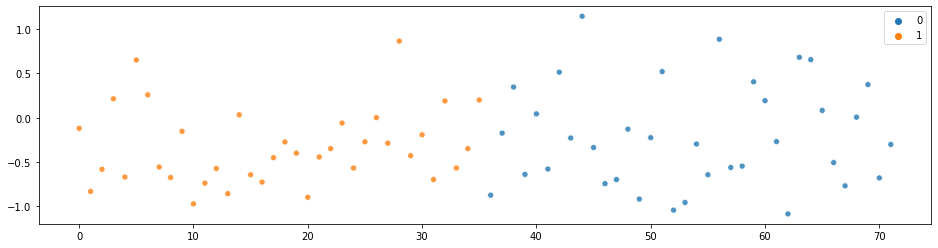

In [54]:
plt.figure(figsize=(16,4))
sns.scatterplot(x=range(len(round_test_out)),
                y=test_output[:,0],
                hue=test_labels,
                alpha=0.8)

## Save Model

In [ ]:
model_root = 'models/'
model_name = 'multi-channel_recurrent'
model_suffix = '.h5'
model_path = model_root + model_name + model_suffix

In [ ]:
model.save(model_path)